# Music genre classification using Clustering and ROM 
The dataset consists of 1000 audio tracks every 30 seconds in duration. It contains 10 genres, each represented by 100 tracks. The tracks are 16-bit monophonic audio files at 22050Hz in .wav format. Your task is to extract audio features and create a model capable of classifying tracks by genre using these features. You may find this [notebook](https://colab.research.google.com/github/emmanueliarussi/DataScienceCapstone/blob/master/3_MidtermProjects/ProjectGTZ/additional/Test_Audio.ipynb.ipynb) useful for opening and exploring audio tracks. For this project, try to put more emphasis on the feature extraction side than on the classifier model. More information [here](https://www.kaggle.com/carlthome/gtzan-genre-collection).


In [1]:
# Download data
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot http://opihi.cs.uvic.ca/sound/genres.tar.gz

--2021-12-01 14:32:51--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225571541 (1.1G) [application/x-gzip]
Saving to: ‘dataroot/genres.tar.gz’

genres.tar.gz       100%[===================>]   1.14G  1018KB/s    in 20m 10s 

2021-12-01 14:53:02 (989 KB/s) - ‘dataroot/genres.tar.gz’ saved [1225571541/1225571541]



In [2]:
# Unzip data
import tarfile
with tarfile.open(dataroot+"genres.tar.gz","r:gz") as tar_ref:
    tar_ref.extractall(dataroot)
    tar_ref.close()

In [3]:
import os
from os import listdir
from os.path import isfile, join

#Eliminate extra files
mypath = "dataroot/genres"

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for i in onlyfiles:
  if os.path.exists(mypath+"/"+i):
    os.remove(mypath+"/"+i)
  else:
    print("The file does not exist")

### Feature extraction

The features of interest for this classification can be divided into "time domain", "frequency domain" and "time-frequency domain" features. Where the following can be considered in each case:

* Time domain features :

* * Amplitude envelope (AE)

* * Root -mean-squared energy (RMS)
* * Zero crossing Rate (ZCR)

* Frequency domain features :
* * Band energy ration (BER): It can be interpreted as a measure the relevance of the low frequency components
* * Spectral centroid (SC): It refers to the frequency band where most of the energy is concentrated and it can be interpreted as a measurement of the brightness of the audio track
* * Bandwidth (Bw): Basically, we can think of it as the variance from the spectral centroid

* Time Frequency domain features :
* * Spectrograms
* * Mel - Spectograms, which, basically refers to a proyection of the Spectograms over a given number of frequency bands. It also considers a rescaling process in order to map frequency considering the human perception of frequency variation (which is log and not linear)
* * Mel spectogram Cepstral Coefficients: which refers to the coefficients of the Fourier transform applied to the Mel-spectogram of a given Track. Which talks about the variation of Mel bands influence over quenfrecy [ms]
Usually, low coefficients refers to envelope components, while high coefficients refer to noise, carrier, etc components.

Time-Frequency domain features, such as Stectograms, mel-spectograms and, MFCCs, are commonly used in Deep Learning apps as they bring information about the frequency components of the audio track, and its variations over time.

###### Time Domain Features

In [ ]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd

In [ ]:
#Probe data loading with librosa
metal0_file = "dataroot/genres/metal/metal.00090.wav"
#ipd.Audio(metal0_file)
metal0, sr = librosa.load(metal0_file)

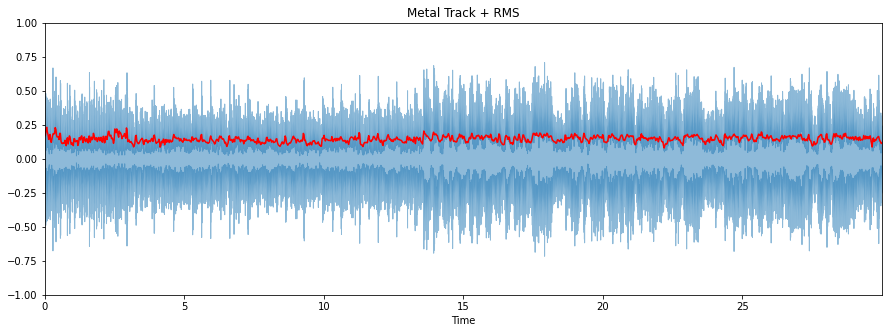

In [ ]:
# RMS extraction with librosa
FRAME_SIZE = 1024
HOP_LENGTH = 512


rms_metal0 = librosa.feature.rms(metal0, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

#Visualization
#time axis generation
frames = range(len(rms_metal0))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

# rms energy is graphed in red
plt.figure(figsize=(15, 17))
ax = plt.subplot(3, 1, 1)
librosa.display.waveplot(metal0, alpha=0.5)
plt.plot(t, rms_metal0, color="r")
plt.ylim((-1, 1))
plt.title("Metal Track + RMS")

plt.show()

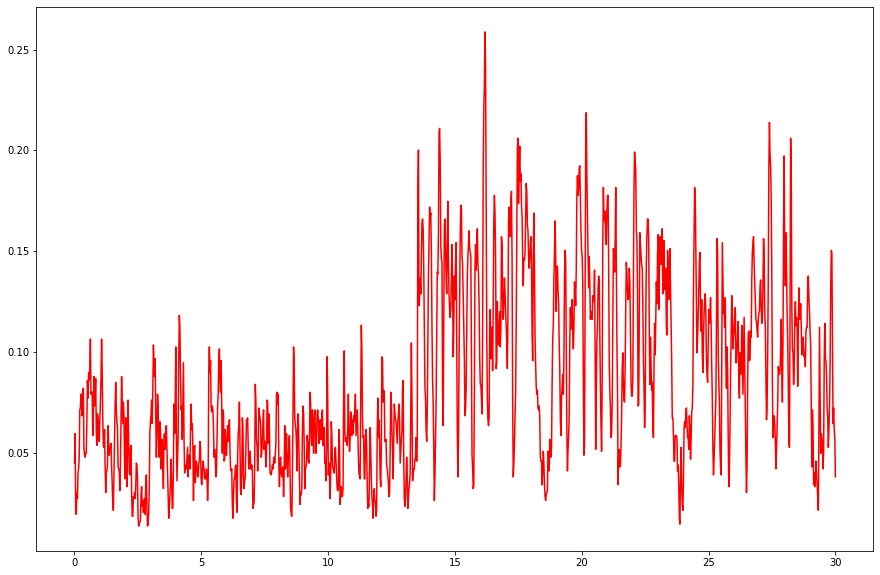

In [ ]:
# Zero crossing rate (ZCR) extraction with librosa
FRAME_SIZE = 1024
HOP_LENGTH = 512

zcr_metal0= librosa.feature.zero_crossing_rate(metal0, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

#Visualization
#time axis generation
frames = range(len(rms_metal0))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

plt.figure(figsize=(15, 10))
plt.plot(t, zcr_metal0, color="r")
plt.show()

In [ ]:
rms_metal0.size

1293

In [ ]:
#useful
#zcr_metal0.size
#zcr_metal0.mean()
#zcr_metal0.std()

0.04505992590802898

###### Frequency Domain features

In [ ]:
#imports 
import math
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd

In [ ]:
#Probe data loading with librosa
metal0_file = "dataroot/genres/metal/metal.00090.wav"
# load audio files with librosa
metal0, sr = librosa.load(metal0_file)

In [ ]:
#Spectogram extraction
FRAME_SIZE = 1024
HOP_SIZE = 512

metal0_spec = librosa.stft(metal0, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

In [ ]:
#Calculate the bin that represents the division between high freq band and low freq band
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)


#Calculate the BER as the ratio between power in low and high freq bands
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

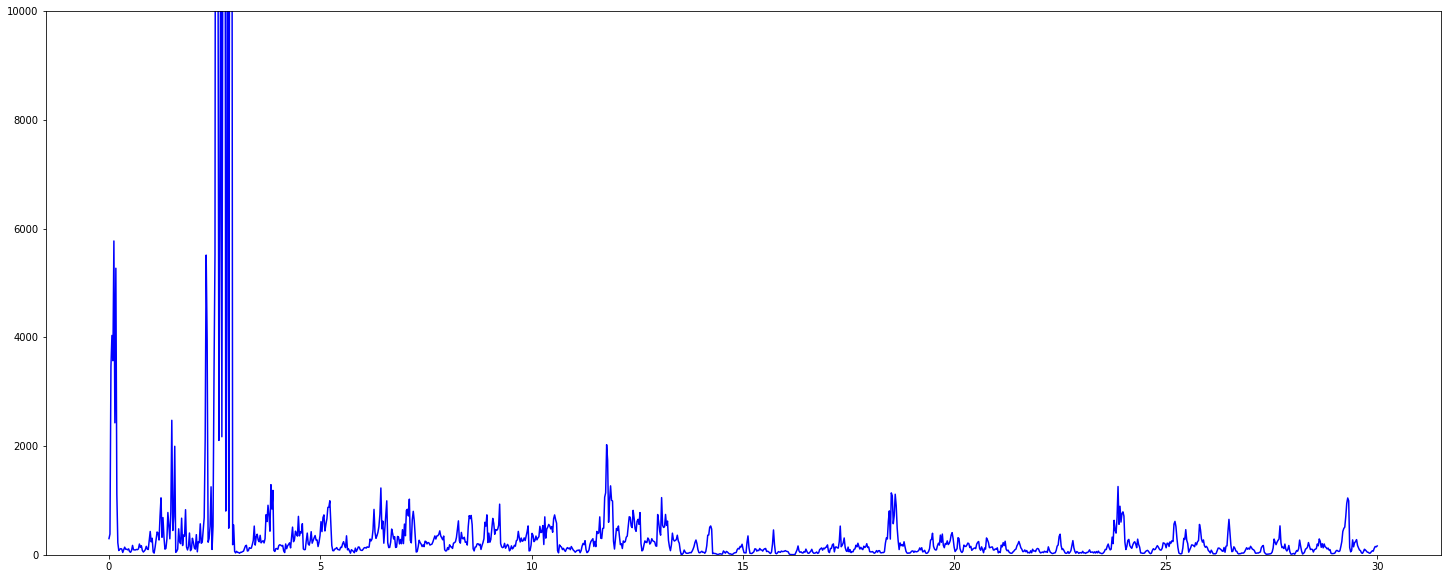

In [ ]:
#Probe considering split freq as 2000Hz
ber_metal0 = band_energy_ratio(metal0_spec, 2000, sr)

#Visualization
#time axis generation
frames = range(len(ber_metal0))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

plt.figure(figsize=(25, 10))
plt.plot(t, ber_metal0, color="b")
plt.ylim((0, 10000))
plt.show()

In [ ]:
ber_metal0.size

1293

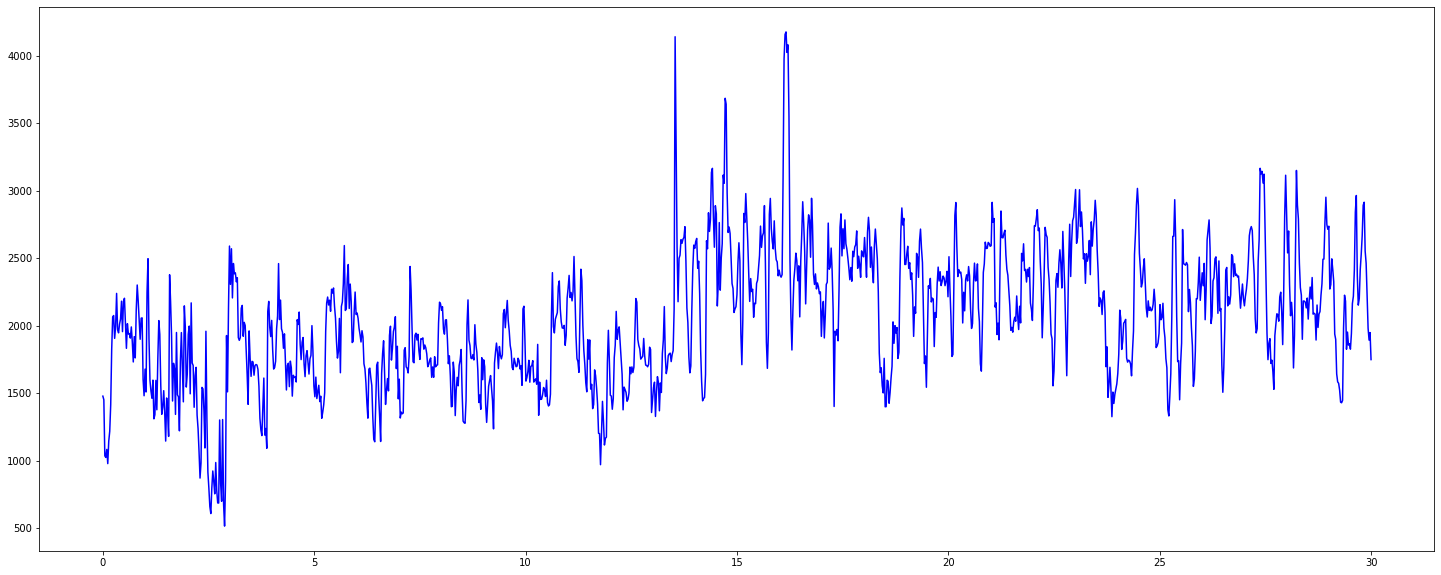

In [ ]:
# Spectral Centroid extraction and visualization
sc_metal0 = librosa.feature.spectral_centroid(y=metal0, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

plt.figure(figsize=(25, 10))
plt.plot(t, sc_metal0, color="b")
#plt.ylim((0, 5000))
plt.show()

In [ ]:
sc_metal0.shape #We get a value for each frame

(1293,)

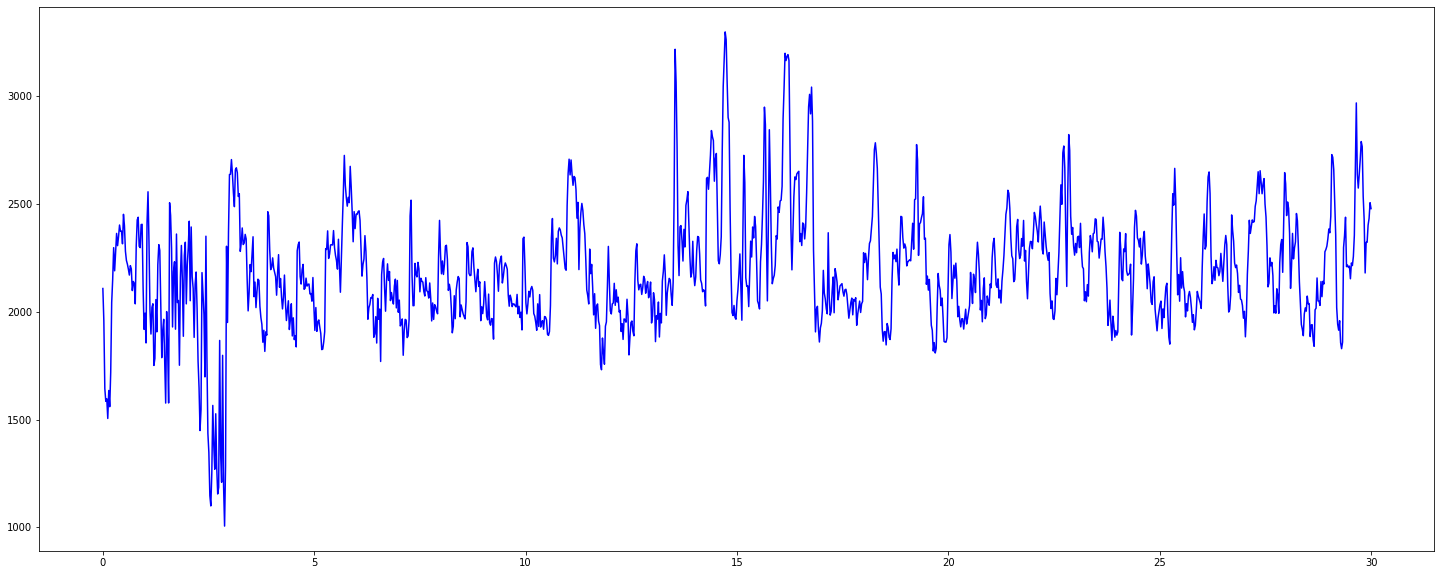

In [ ]:
# Spectral BW extraction and visualization
sbw_metal0 = librosa.feature.spectral_bandwidth(y=metal0, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

plt.figure(figsize=(25, 10))
plt.plot(t, sbw_metal0, color="b")
#plt.ylim((0, 5000))
plt.show()


In [ ]:
sbw_metal0.shape #idem

(1293,)

##### Time-Frequency Domain Features

Mostly, I'll be using the Mel-Frequency Cepstral Coefficients and its first 2 derivatives, because they represent the change in this representation over the time of the audio track/data

In [ ]:
#Get 13 MFCCs
mfcc_metal0 = librosa.feature.mfcc(y=metal0, n_mfcc=13, sr=sr)
#First Derivative
delta_mfccs_metal0 = librosa.feature.delta(mfcc_metal0)
#Second Derivative
delta2_mfccs_metal0 = librosa.feature.delta(mfcc_metal0, order=2)

##### Visualization of MFCCs

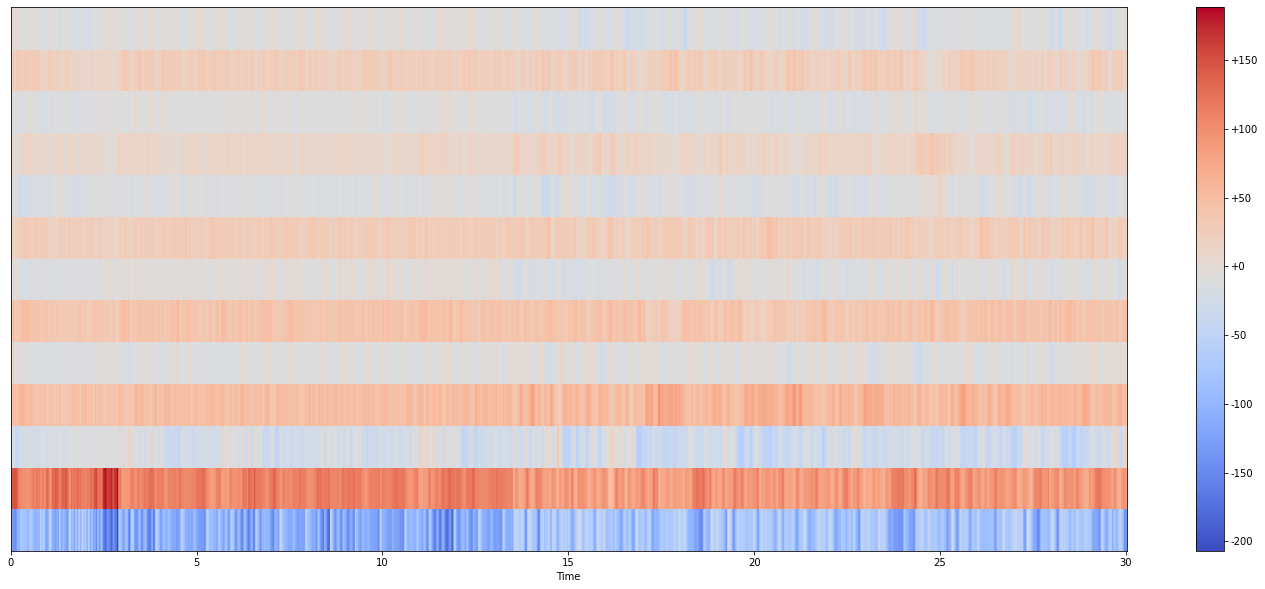

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfcc_metal0, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

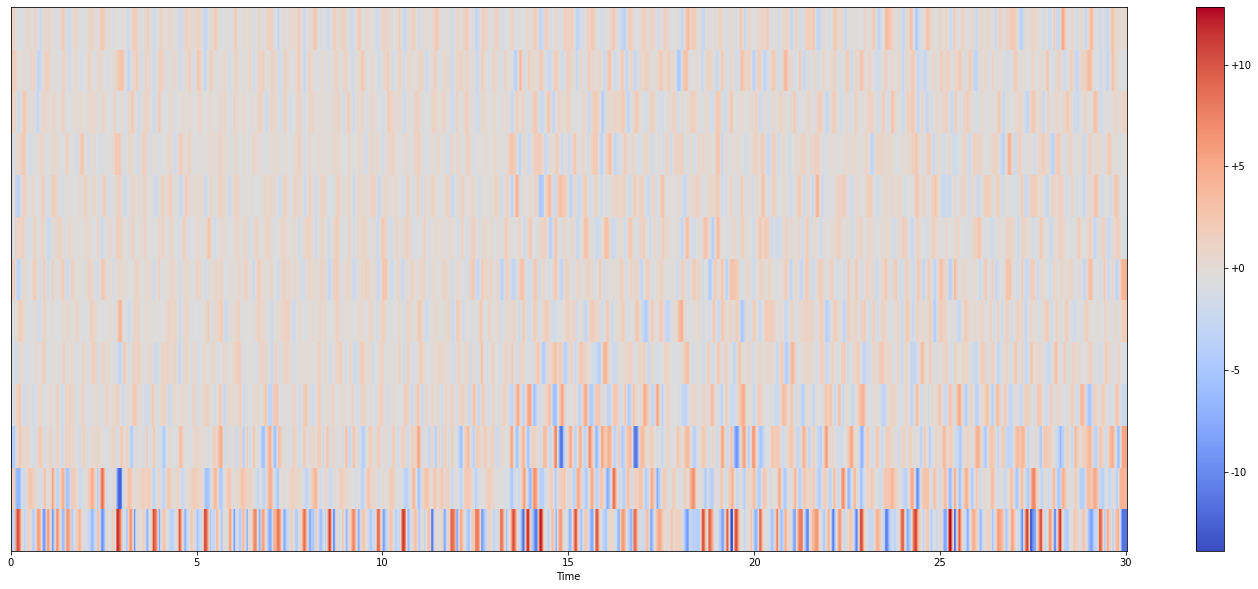

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta_mfccs_metal0, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

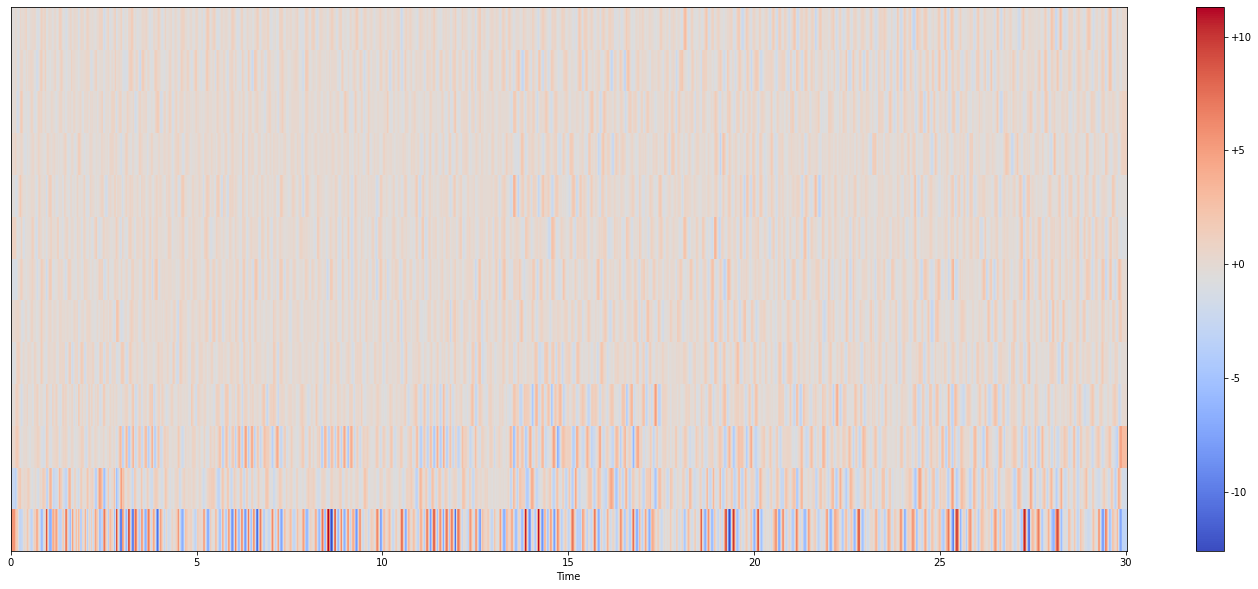

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta2_mfccs_metal0, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

### Feature Vector
As most of the feature whereas they are time domain, frequency domain or time-frequency domain, are calculated for each frame of the audio track, I need to reduce the order of the features I'll feed into de classifier.

In order to do that, I'll calculate the mean and the std of each feature along the audio track. So, instead of having 1293 values for each feature in each audio track, I'll have only 2.

In [ ]:
#Time
rms_mean = rms_metal0.mean()
rms_std = rms_metal0.std()

zcr_mean = zcr_metal0.mean()
zcr_std = zcr_metal0.std()

#Frequency
ber_mean = ber_metal0.mean()
ber_std = ber_metal0.std()

sc_mean = sc_metal0.mean()
sc_std = sc_metal0.std()

sbw_mean = sbw_metal0.mean()
sbw_sd = sbw_metal0.std()

1

In [ ]:
mfcc_mean = [0 for i in range(mfcc_metal0.shape[0])]
mfcc_std = [0 for i in range(mfcc_metal0.shape[0])]

delta_mfcc_mean = [0 for i in range(mfcc_metal0.shape[0])]
delta_mfcc_std = [0 for i in range(mfcc_metal0.shape[0])]

delta2_mfcc_mean = [0 for i in range(mfcc_metal0.shape[0])]
delta2_mfcc_std = [0 for i in range(mfcc_metal0.shape[0])]


for i in range(mfcc_metal0.shape[0]):
  mfcc_mean[i] = mfcc_metal0[i,:].mean()
  mfcc_std[i] = mfcc_metal0[i,:].std()

  delta_mfcc_mean[i] = delta_mfccs_metal0[i,:].mean()
  delta_mfcc_std[i] = delta_mfccs_metal0[i,:].std()

  delta2_mfcc_mean[i] = delta2_mfccs_metal0[i,:].mean()
  delta2_mfcc_std[i] = delta2_mfccs_metal0[i,:].std()



In [ ]:
len(delta_mfcc_mean)

13

### Loading Data

The aim of this section is to load the data to turn it in a structured data set, i.e, into a DataFrame to feed into the Clasiffier.


In [4]:
import json
import os
import math

import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd



DATASET_PATH = "dataroot"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

FRAME_SIZE = 1024
HOP_LENGTH = 512





#Calculate the bin that represents the division between high freq band and low freq band
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)


#Calculate the BER as the ratio between power in low and high freq bands
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)







def save_feature(dataset_path, json_path, num_mfcc=13, n_fft=2048, frame_size = 1024 ,hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :para frame_size(int): Number of samples in each frame for time domain feature extraction
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "RMS_MEAN": [],
        "RMS_STD": [],
        "ZCR_MEAN": [],
        "ZCR_STD": [],
        "BER_MEAN": [],
        "BER_STD": [],
        "SC_MEAN": [],
        "SC_STD": [],
        "SBW_MEAN": [],
        "SBW_STD": [],
        "MFCC_MEAN": [],
        "MFCC_STD": [],
        "DELTA_MFCC_MEAN": [],
        "DELTA_MFCC_STD": [],
        "DELTA2_MFCC_MEAN": [],
        "DELTA2_MFCC_STD" : []

    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

	            	# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                
                data["labels"].append(i-1)

                #--------------------
                #Time domain features
                rms_signal = librosa.feature.rms(signal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
                zcr_signal= librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
                #Feature reduction
                rms_mean = rms_signal.mean()
                rms_std = rms_signal.std()
                zcr_mean = zcr_signal.mean()
                zcr_std = zcr_signal.std()
                data["RMS_MEAN"].append(rms_mean)
                data["RMS_STD"].append(rms_std)
                data["ZCR_MEAN"].append(zcr_mean)
                data["ZCR_STD"].append(zcr_std)

                #--------------------
                #Frequency domain features
                spec_signal = librosa.stft(signal, n_fft=n_fft, hop_length=HOP_LENGTH)
                ber_signal = band_energy_ratio(spec_signal, 2000, sample_rate)
                sc_signal = librosa.feature.spectral_centroid(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=HOP_LENGTH)[0]
                sbw_signal = librosa.feature.spectral_bandwidth(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=HOP_LENGTH)[0]
                #
                ber_mean = ber_signal.mean()
                ber_std = ber_signal.std()

                sc_mean = sc_signal.mean()
                sc_std = sc_signal.std()

                sbw_mean = sbw_signal.mean()
                sbw_std = sbw_signal.std()

                data["BER_MEAN"].append(ber_mean)
                data["BER_STD"].append(ber_std)
                data["SC_MEAN"].append(sc_mean)
                data["SC_STD"].append(sc_std)
                data["SBW_MEAN"].append(sbw_mean)
                data["SBW_STD"].append(sbw_std)

                #--------------------
                #Time Frequency Domain Features
                #Get 13 MFCCs
                mfcc_signal = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sample_rate)
                #First Derivative
                delta_mfccs_signal = librosa.feature.delta(mfcc_signal)
                #Second Derivative
                delta2_mfccs_sinal = librosa.feature.delta(mfcc_signal, order=2)   

                mfcc_mean = [0 for i in range(mfcc_signal.shape[0])]
                mfcc_std = [0 for i in range(mfcc_signal.shape[0])]

                delta_mfcc_mean = [0 for i in range(mfcc_signal.shape[0])]
                delta_mfcc_std = [0 for i in range(mfcc_signal.shape[0])]

                delta2_mfcc_mean = [0 for i in range(mfcc_signal.shape[0])]
                delta2_mfcc_std = [0 for i in range(mfcc_signal.shape[0])]


                for j in range(mfcc_signal.shape[0]):
                  mfcc_mean[j] = mfcc_signal[j,:].mean()
                  mfcc_std[j] = mfcc_signal[j,:].std()

                  delta_mfcc_mean[j] = delta_mfccs_signal[j,:].mean()
                  delta_mfcc_std[j] = delta_mfccs_signal[j,:].std()

                  delta2_mfcc_mean[j] = delta2_mfccs_sinal[j,:].mean()
                  delta2_mfcc_std[j] = delta2_mfccs_sinal[j,:].std()

                """data["MFCC_MEAN"].append(mfcc_mean.tolist())
                data["MFCC_STD"].append(mfcc_std.tolist())
                data["DELTA_MFCC_MEAN"].append(delta_mfcc_mean.tolist())
                data["DELTA_MFCC_STD"].append(delta_mfcc_std.tolist())
                data["DELTA2_MFCC_MEAN"].append(delta2_mfcc_mean.tolist())
                data["DELTA2_MFCC_STD"].append(delta2_mfcc_std.tolist())"""
                data["MFCC_MEAN"].append(mfcc_mean)
                data["MFCC_STD"].append(mfcc_std)
                data["DELTA_MFCC_MEAN"].append(delta_mfcc_mean)
                data["DELTA_MFCC_STD"].append(delta_mfcc_std)
                data["DELTA2_MFCC_MEAN"].append(delta2_mfcc_mean)
                data["DELTA2_MFCC_STD"].append(delta2_mfcc_std)


    return data
    # save MFCCs to json file
    #with open(json_path, "w") as fp:
    #    json.dump(data, fp, indent=4)


In [5]:
DATA_DICT = save_feature(DATASET_PATH, JSON_PATH, frame_size = FRAME_SIZE ,hop_length=HOP_LENGTH)


Processing: genres

Processing: metal

Processing: country

Processing: reggae

Processing: blues

Processing: pop

Processing: hiphop


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in float_scalars



Processing: disco

Processing: jazz

Processing: rock

Processing: classical


In [6]:
#save MFCCs to json file
#with open(JSON_PATH, "w") as fp:
#  json.dump(str(DATA_DICT), fp, indent=4)

In [7]:
#import pandas as pd
#data_path = "/content/data_10.json"
#with open(data_path, "r") as fp:
#        jsonread = json.load(fp)
#pd.read_json().head()
#jsonread = pd.read_json("data_10.json") 
#jsondf = pd.DataFrame(jsonread.features.values.tolist)

##### DATAFRAME generation

In this section, the dataframe to feed into de Classification model is generated from the dictionary 'DATA_DICT'.

MFCC data is reshaped to generate a different column for each coefficient in each track.

In [8]:
import pandas as pd
df = pd.DataFrame(DATA_DICT['labels'], columns=['labels'])

keys = DATA_DICT.keys()
keys = list(keys)
keys = keys[2:-6]
for i in keys:
  df[i] = DATA_DICT[i]

df.head()


,labels,RMS_MEAN,RMS_STD,ZCR_MEAN,ZCR_STD,BER_MEAN,BER_STD,SC_MEAN,SC_STD,SBW_MEAN,SBW_STD
0,1,0.096823,0.022727,0.137325,0.036300,8.756252,10.521786,2269.128009,368.502598,1928.953538,297.405778
1,1,0.118122,0.014470,0.180243,0.043741,4.206675,4.114486,2291.649003,361.111894,1583.767425,185.801932
2,1,0.115384,0.034663,0.120014,0.049170,23.082312,34.066628,2323.458546,465.255350,2263.691596,204.960312
3,1,0.267456,0.054046,0.131752,0.053436,13.463575,16.897223,2814.978063,603.359566,2548.011410,321.530788
4,1,0.124836,0.029430,0.139455,0.042735,10.439021,11.110479,2315.317248,339.486048,2066.651952,192.600673


In [9]:
import numpy as np

columns_mfcc_mean = ["MFCC_MEAN_"+str(i+1) for i in range(13)]
columns_mfcc_std = ["MFCC_STD_"+str(i+1) for i in range(13)]

columns_delta_mfcc_mean = ["DELTA_MFCC_MEAN_"+str(i+1) for i in range(13)]
columns_delta_mfcc_std = ["DELTA_MFCC_STD_"+str(i+1) for i in range(13)]

columns_delta2_mfcc_mean = ["DELTA2_MFCC_MEAN_"+str(i+1) for i in range(13)]
columns_delta2_mfcc_std = ["DELTA2_MFCC_STD_"+str(i+1) for i in range(13)]


df_MFCC_MEAN = pd.DataFrame(np.array(DATA_DICT['MFCC_MEAN']), columns = columns_mfcc_mean)
df_MFCC_STD = pd.DataFrame(np.array(DATA_DICT['MFCC_STD']), columns = columns_mfcc_std)

df_DELTA_MFCC_MEAN = pd.DataFrame(np.array(DATA_DICT['DELTA_MFCC_MEAN']), columns = columns_delta_mfcc_mean)
df_DELTA_MFCC_STD = pd.DataFrame(np.array(DATA_DICT['DELTA_MFCC_STD']), columns = columns_delta_mfcc_std)

df_DELTA2_MFCC_MEAN = pd.DataFrame(np.array(DATA_DICT['DELTA2_MFCC_MEAN']), columns = columns_delta2_mfcc_mean)
df_DELTA2_MFCC_STD = pd.DataFrame(np.array(DATA_DICT['DELTA2_MFCC_STD']), columns = columns_delta2_mfcc_std)


df_MFCC_MEAN.head()



,MFCC_MEAN_1,MFCC_MEAN_2,MFCC_MEAN_3,MFCC_MEAN_4,MFCC_MEAN_5,MFCC_MEAN_6,MFCC_MEAN_7,MFCC_MEAN_8,MFCC_MEAN_9,MFCC_MEAN_10,MFCC_MEAN_11,MFCC_MEAN_12,MFCC_MEAN_13
0,-100.384117,104.688103,-57.247860,56.568504,-5.551697,22.824835,-6.165266,23.091785,-19.065331,17.791447,-13.772540,9.958725,-14.852404
1,-76.324715,123.248238,-89.870193,76.425598,-21.256561,22.300777,-13.654284,14.645465,-6.313653,9.904276,-3.925295,5.393331,-2.484235
2,-96.612671,101.737526,-16.849163,47.305790,-27.102179,28.294376,-17.193653,21.651680,-17.899788,7.029617,-14.611753,15.236002,-16.015682
3,-1.639786,73.393372,-15.902726,55.797817,-1.897447,34.024055,-8.308772,32.758251,-9.702256,20.829285,-9.034417,13.955179,-9.579517
4,-58.227161,105.840187,-43.884415,58.440044,-18.423309,27.966845,-17.959604,21.040768,-15.545892,13.387969,-15.680117,9.359065,-15.315594


In [10]:
df_tot = pd.concat([df, df_MFCC_MEAN,df_MFCC_STD,df_DELTA_MFCC_MEAN,df_DELTA_MFCC_STD, df_DELTA2_MFCC_MEAN,df_DELTA2_MFCC_STD], axis=1)

df_tot.head()

,labels,RMS_MEAN,RMS_STD,ZCR_MEAN,ZCR_STD,BER_MEAN,BER_STD,SC_MEAN,SC_STD,SBW_MEAN,SBW_STD,MFCC_MEAN_1,MFCC_MEAN_2,MFCC_MEAN_3,MFCC_MEAN_4,MFCC_MEAN_5,MFCC_MEAN_6,MFCC_MEAN_7,MFCC_MEAN_8,MFCC_MEAN_9,MFCC_MEAN_10,MFCC_MEAN_11,MFCC_MEAN_12,MFCC_MEAN_13,MFCC_STD_1,MFCC_STD_2,MFCC_STD_3,MFCC_STD_4,MFCC_STD_5,MFCC_STD_6,MFCC_STD_7,MFCC_STD_8,MFCC_STD_9,MFCC_STD_10,MFCC_STD_11,MFCC_STD_12,MFCC_STD_13,DELTA_MFCC_MEAN_1,DELTA_MFCC_MEAN_2,DELTA_MFCC_MEAN_3,...,DELTA_MFCC_MEAN_13,DELTA_MFCC_STD_1,DELTA_MFCC_STD_2,DELTA_MFCC_STD_3,DELTA_MFCC_STD_4,DELTA_MFCC_STD_5,DELTA_MFCC_STD_6,DELTA_MFCC_STD_7,DELTA_MFCC_STD_8,DELTA_MFCC_STD_9,DELTA_MFCC_STD_10,DELTA_MFCC_STD_11,DELTA_MFCC_STD_12,DELTA_MFCC_STD_13,DELTA2_MFCC_MEAN_1,DELTA2_MFCC_MEAN_2,DELTA2_MFCC_MEAN_3,DELTA2_MFCC_MEAN_4,DELTA2_MFCC_MEAN_5,DELTA2_MFCC_MEAN_6,DELTA2_MFCC_MEAN_7,DELTA2_MFCC_MEAN_8,DELTA2_MFCC_MEAN_9,DELTA2_MFCC_MEAN_10,DELTA2_MFCC_MEAN_11,DELTA2_MFCC_MEAN_12,DELTA2_MFCC_MEAN_13,DELTA2_MFCC_STD_1,DELTA2_MFCC_STD_2,DELTA2_MFCC_STD_3,DELTA2_MFCC_STD_4,DELTA2_MFCC_STD_5,DELTA2_MFCC_STD_6,DELTA2_MFCC_STD_7,DELTA2_MFCC_STD_8,DELTA2_MFCC_STD_9,DELTA2_MFCC_STD_10,DELTA2_MFCC_STD_11,DELTA2_MFCC_STD_12,DELTA2_MFCC_STD_13
0,1,0.096823,0.022727,0.137325,0.036300,8.756252,10.521786,2269.128009,368.502598,1928.953538,297.405778,-100.384117,104.688103,-57.247860,56.568504,-5.551697,22.824835,-6.165266,23.091785,-19.065331,17.791447,-13.772540,9.958725,-14.852404,36.413612,19.851084,18.149982,10.638103,9.670060,10.065142,10.502202,8.878150,7.086769,7.212884,6.944951,7.072001,6.990023,0.041205,-0.020070,0.006459,...,-0.007765,6.889660,3.591405,3.361026,1.727049,1.574622,1.745095,1.903331,1.326078,1.245921,1.244116,1.248947,1.138499,1.261795,-0.016655,0.010020,-0.006765,-0.005973,0.002257,-0.008525,0.007916,0.000507,0.004402,0.004219,0.006742,-0.003314,0.001991,4.376103,1.810100,1.695926,0.962453,0.976496,0.998126,1.115693,0.840971,0.771470,0.754194,0.797552,0.735302,0.761972
1,1,0.118122,0.014470,0.180243,0.043741,4.206675,4.114486,2291.649003,361.111894,1583.767425,185.801932,-76.324715,123.248238,-89.870193,76.425598,-21.256561,22.300777,-13.654284,14.645465,-6.313653,9.904276,-3.925295,5.393331,-2.484235,25.737839,27.167770,14.285209,11.592737,11.359246,8.420270,10.694427,8.813901,10.039080,7.416893,8.820149,7.431227,6.932764,0.013605,-0.024346,-0.012397,...,-0.002824,4.100523,3.883790,2.420053,1.848660,1.719585,1.574463,1.559043,1.532300,1.522153,1.329758,1.306857,1.182971,1.003226,0.009882,-0.022571,0.020972,-0.008489,0.008891,-0.000199,-0.001008,-0.003826,0.010985,-0.008336,0.001413,-0.004436,-0.001198,2.741904,2.502889,1.470644,1.047021,1.161875,1.014714,1.030790,0.986495,0.958628,0.894385,0.890193,0.796501,0.642587
2,1,0.115384,0.034663,0.120014,0.049170,23.082312,34.066628,2323.458546,465.255350,2263.691596,204.960312,-96.612671,101.737526,-16.849163,47.305790,-27.102179,28.294376,-17.193653,21.651680,-17.899788,7.029617,-14.611753,15.236002,-16.015682,41.780117,19.229631,16.529913,10.727819,10.089458,9.533232,7.910773,6.436266,7.161498,7.241937,8.573326,6.738318,6.767535,0.021175,-0.010046,0.004322,...,0.005851,5.766936,2.933746,2.182423,1.729464,1.415131,1.453543,1.236874,1.165241,1.182703,1.196438,1.104061,1.116316,1.134486,-0.016093,0.011499,0.005808,-0.000243,0.009766,0.005529,0.002963,0.000218,0.001043,-0.006221,0.010316,-0.000079,0.007630,3.599455,1.583569,1.108146,0.946042,0.897958,0.896193,0.720998,0.732834,0.715959,0.802517,0.694850,0.753860,0.704964
3,1,0.267456,0.054046,0.131752,0.053436,13.463575,16.897223,2814.978063,603.359566,2548.011410,321.530788,-1.639786,73.393372,-15.902726,55.797817,-1.897447,34.024055,-8.308772,32.758251,-9.702256,20.829285,-9.034417,13.955179,-9.579517,35.490417,20.535940,17.164835,14.640574,10.063139,10.997406,10.199425,9.863175,8.914000,7.458994,7.421149,7.521737,6.848709,-0.039111,-0.017733,-0.007620,...,0.004835,6.667572,4.138603,3.234592,2.702840,1.859616,2.064569,2.025428,1.912094,1.661526,1.397564,1.420607,1.399976,1.258849,-0.0

In [11]:
df_tot

,labels,RMS_MEAN,RMS_STD,ZCR_MEAN,ZCR_STD,BER_MEAN,BER_STD,SC_MEAN,SC_STD,SBW_MEAN,SBW_STD,MFCC_MEAN_1,MFCC_MEAN_2,MFCC_MEAN_3,MFCC_MEAN_4,MFCC_MEAN_5,MFCC_MEAN_6,MFCC_MEAN_7,MFCC_MEAN_8,MFCC_MEAN_9,MFCC_MEAN_10,MFCC_MEAN_11,MFCC_MEAN_12,MFCC_MEAN_13,MFCC_STD_1,MFCC_STD_2,MFCC_STD_3,MFCC_STD_4,MFCC_STD_5,MFCC_STD_6,MFCC_STD_7,MFCC_STD_8,MFCC_STD_9,MFCC_STD_10,MFCC_STD_11,MFCC_STD_12,MFCC_STD_13,DELTA_MFCC_MEAN_1,DELTA_MFCC_MEAN_2,DELTA_MFCC_MEAN_3,...,DELTA_MFCC_MEAN_13,DELTA_MFCC_STD_1,DELTA_MFCC_STD_2,DELTA_MFCC_STD_3,DELTA_MFCC_STD_4,DELTA_MFCC_STD_5,DELTA_MFCC_STD_6,DELTA_MFCC_STD_7,DELTA_MFCC_STD_8,DELTA_MFCC_STD_9,DELTA_MFCC_STD_10,DELTA_MFCC_STD_11,DELTA_MFCC_STD_12,DELTA_MFCC_STD_13,DELTA2_MFCC_MEAN_1,DELTA2_MFCC_MEAN_2,DELTA2_MFCC_MEAN_3,DELTA2_MFCC_MEAN_4,DELTA2_MFCC_MEAN_5,DELTA2_MFCC_MEAN_6,DELTA2_MFCC_MEAN_7,DELTA2_MFCC_MEAN_8,DELTA2_MFCC_MEAN_9,DELTA2_MFCC_MEAN_10,DELTA2_MFCC_MEAN_11,DELTA2_MFCC_MEAN_12,DELTA2_MFCC_MEAN_13,DELTA2_MFCC_STD_1,DELTA2_MFCC_STD_2,DELTA2_MFCC_STD_3,DELTA2_MFCC_STD_4,DELTA2_MFCC_STD_5,DELTA2_MFCC_STD_6,DELTA2_MFCC_STD_7,DELTA2_MFCC_STD_8,DELTA2_MFCC_STD_9,DELTA2_MFCC_STD_10,DELTA2_MFCC_STD_11,DELTA2_MFCC_STD_12,DELTA2_MFCC_STD_13
0,1,0.096823,0.022727,0.137325,0.036300,8.756252,10.521786,2269.128009,368.502598,1928.953538,297.405778,-100.384117,104.688103,-57.247860,56.568504,-5.551697,22.824835,-6.165266,23.091785,-19.065331,17.791447,-13.772540,9.958725,-14.852404,36.413612,19.851084,18.149982,10.638103,9.670060,10.065142,10.502202,8.878150,7.086769,7.212884,6.944951,7.072001,6.990023,0.041205,-0.020070,0.006459,...,-0.007765,6.889660,3.591405,3.361026,1.727049,1.574622,1.745095,1.903331,1.326078,1.245921,1.244116,1.248947,1.138499,1.261795,-0.016655,0.010020,-0.006765,-0.005973,0.002257,-0.008525,0.007916,0.000507,0.004402,0.004219,0.006742,-0.003314,0.001991,4.376103,1.810100,1.695926,0.962453,0.976496,0.998126,1.115693,0.840971,0.771470,0.754194,0.797552,0.735302,0.761972
1,1,0.118122,0.014470,0.180243,0.043741,4.206675,4.114486,2291.649003,361.111894,1583.767425,185.801932,-76.324715,123.248238,-89.870193,76.425598,-21.256561,22.300777,-13.654284,14.645465,-6.313653,9.904276,-3.925295,5.393331,-2.484235,25.737839,27.167770,14.285209,11.592737,11.359246,8.420270,10.694427,8.813901,10.039080,7.416893,8.820149,7.431227,6.932764,0.013605,-0.024346,-0.012397,...,-0.002824,4.100523,3.883790,2.420053,1.848660,1.719585,1.574463,1.559043,1.532300,1.522153,1.329758,1.306857,1.182971,1.003226,0.009882,-0.022571,0.020972,-0.008489,0.008891,-0.000199,-0.001008,-0.003826,0.010985,-0.008336,0.001413,-0.004436,-0.001198,2.741904,2.502889,1.470644,1.047021,1.161875,1.014714,1.030790,0.986495,0.958628,0.894385,0.890193,0.796501,0.642587
2,1,0.115384,0.034663,0.120014,0.049170,23.082312,34.066628,2323.458546,465.255350,2263.691596,204.960312,-96.612671,101.737526,-16.849163,47.305790,-27.102179,28.294376,-17.193653,21.651680,-17.899788,7.029617,-14.611753,15.236002,-16.015682,41.780117,19.229631,16.529913,10.727819,10.089458,9.533232,7.910773,6.436266,7.161498,7.241937,8.573326,6.738318,6.767535,0.021175,-0.010046,0.004322,...,0.005851,5.766936,2.933746,2.182423,1.729464,1.415131,1.453543,1.236874,1.165241,1.182703,1.196438,1.104061,1.116316,1.134486,-0.016093,0.011499,0.005808,-0.000243,0.009766,0.005529,0.002963,0.000218,0.001043,-0.006221,0.010316,-0.000079,0.007630,3.599455,1.583569,1.108146,0.946042,0.897958,0.896193,0.720998,0.732834,0.715959,0.802517,0.694850,0.753860,0.704964
3,1,0.267456,0.054046,0.131752,0.053436,13.463575,16.897223,2814.978063,603.359566,2548.011410,321.530788,-1.639786,73.393372,-15.902726,55.797817,-1.897447,34.024055,-8.308772,32.758251,-9.702256,20.829285,-9.034417,13.955179,-9.579517,35.490417,20.535940,17.164835,14.640574,10.063139,10.997406,10.199425,9.863175,8.914000,7.458994,7.421149,7.521737,6.848709,-0.039111,-0.017733,-0.007620,...,0.004835,6.667572,4.138603,3.234592,2.702840,1.859616,2.064569,2.025428,1.912094,1.661526,1.397564,1.420607,1.399976,1.258849,-0.0

In [12]:
df_tot.dropna( inplace=True)

### SVM classification

In this section, the SVM classificator will be defined, trained and optimised.


In [ ]:
#Imports
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA

In [ ]:
#Split data into inputs and outputs
X = df_tot.drop('labels', axis=1).copy()
X.head()



,RMS_MEAN,RMS_STD,ZCR_MEAN,ZCR_STD,BER_MEAN,BER_STD,SC_MEAN,SC_STD,SBW_MEAN,SBW_STD,MFCC_MEAN_1,MFCC_MEAN_2,MFCC_MEAN_3,MFCC_MEAN_4,MFCC_MEAN_5,MFCC_MEAN_6,MFCC_MEAN_7,MFCC_MEAN_8,MFCC_MEAN_9,MFCC_MEAN_10,MFCC_MEAN_11,MFCC_MEAN_12,MFCC_MEAN_13,MFCC_STD_1,MFCC_STD_2,MFCC_STD_3,MFCC_STD_4,MFCC_STD_5,MFCC_STD_6,MFCC_STD_7,MFCC_STD_8,MFCC_STD_9,MFCC_STD_10,MFCC_STD_11,MFCC_STD_12,MFCC_STD_13,DELTA_MFCC_MEAN_1,DELTA_MFCC_MEAN_2,DELTA_MFCC_MEAN_3,DELTA_MFCC_MEAN_4,...,DELTA_MFCC_MEAN_13,DELTA_MFCC_STD_1,DELTA_MFCC_STD_2,DELTA_MFCC_STD_3,DELTA_MFCC_STD_4,DELTA_MFCC_STD_5,DELTA_MFCC_STD_6,DELTA_MFCC_STD_7,DELTA_MFCC_STD_8,DELTA_MFCC_STD_9,DELTA_MFCC_STD_10,DELTA_MFCC_STD_11,DELTA_MFCC_STD_12,DELTA_MFCC_STD_13,DELTA2_MFCC_MEAN_1,DELTA2_MFCC_MEAN_2,DELTA2_MFCC_MEAN_3,DELTA2_MFCC_MEAN_4,DELTA2_MFCC_MEAN_5,DELTA2_MFCC_MEAN_6,DELTA2_MFCC_MEAN_7,DELTA2_MFCC_MEAN_8,DELTA2_MFCC_MEAN_9,DELTA2_MFCC_MEAN_10,DELTA2_MFCC_MEAN_11,DELTA2_MFCC_MEAN_12,DELTA2_MFCC_MEAN_13,DELTA2_MFCC_STD_1,DELTA2_MFCC_STD_2,DELTA2_MFCC_STD_3,DELTA2_MFCC_STD_4,DELTA2_MFCC_STD_5,DELTA2_MFCC_STD_6,DELTA2_MFCC_STD_7,DELTA2_MFCC_STD_8,DELTA2_MFCC_STD_9,DELTA2_MFCC_STD_10,DELTA2_MFCC_STD_11,DELTA2_MFCC_STD_12,DELTA2_MFCC_STD_13
0,0.137634,0.078214,0.053303,0.043825,606.667175,2214.302246,1721.088460,837.120346,2312.314590,605.372119,-144.929214,118.459854,20.525322,28.566488,2.356901,10.068707,11.915094,4.848369,-0.087061,3.294274,3.415107,3.655124,5.368891,71.174477,35.826801,18.353529,10.860121,9.234468,8.409963,7.463735,7.292317,8.156244,6.570827,7.364944,6.114866,7.792328,-0.046513,0.008040,-0.013809,-0.012053,...,0.003194,11.941403,7.173334,2.532157,1.783629,1.508978,1.370515,1.207606,1.267586,1.326853,1.108672,1.186882,0.940776,1.189330,0.028212,-0.003839,-0.006913,0.005712,-0.007441,-0.003885,-0.003586,-0.001070,-0.010927,-0.000395,0.002243,0.001211,0.001326,7.894339,4.434835,1.439655,1.097348,0.948251,0.897647,0.786471,0.810624,0.840877,0.747816,0.793542,0.614552,0.709530
1,0.075078,0.049775,0.146248,0.082131,39.289009,216.829285,2521.228725,768.743415,2133.546671,325.283051,-160.125488,88.730690,-35.470551,47.491371,-12.599652,17.294119,-19.137306,14.594136,-20.373800,11.094916,-11.138631,7.693565,-9.857306,104.587959,30.704517,28.528452,19.913654,13.583906,11.970040,11.754415,9.509742,11.758904,10.281279,8.827429,8.468905,7.952126,-0.031596,-0.040460,0.014773,0.018549,...,-0.014934,10.152212,5.609888,3.715932,3.268166,2.324341,1.963715,1.950427,1.552116,1.791087,1.732069,1.503098,1.332553,1.409378,-0.023423,-0.004437,0.015083,-0.005246,0.000198,-0.009304,-0.004238,-0.003376,-0.006725,-0.004170,0.001998,-0.004896,0.003256,7.206436,3.212132,2.236955,1.908096,1.367478,1.209545,1.179252,1.049564,1.123027,1.077349,0.925923,0.870818,0.921971
2,0.179456,0.038560,0.111492,0.053930,27.962393,40.110249,2445.028013,609.936854,2434.018848,331.897766,-42.367630,85.046959,-7.381763,40.717876,-1.010143,18.923517,-3.541921,5.873317,-5.019628,4.245726,-3.176356,-0.579638,-0.528216,37.087418,23.111847,17.576490,11.034577,8.691776,9.150274,7.488344,6.365489,6.485134,6.844398,6.601533,6.674088,6.520505,-0.027845,0.035045,-0.032632,0.008753,...,0.006159,7.508893,4.942181,3.028289,1.855549,1.335115,1.365528,1.146417,0.968939,1.074896,0.954095,0.977876,0.984040,0.959502,0.032633,-0.019678,0.025905,-0.016131,-0.001230,0.000160,-0.008093,-0.004399,0.000674,0.001402,0.001837,-0.000399,0.000501,5.668666,3.762386,1.980577,1.254832,0.732969,0.763463,0.687428,0.637015,0.630358,0.584863,0.636172,0.631177,0.630209
3,0.107988,0.015031,0.150118,0.046977,10.015882,18.728706,2474.257423,508.090724,2123.313457,288.279711,-74.275742,100.125725,-47.363968,49.617355,-18.413784,24.616348,-15.919292,23.896038,-22.835342,23.332420,-16.944992,14.934316,-11.496364,28.874479,21.088095,17.137987,10.838228,8.232019,6.938890,7.948340,6.509963,5.780666,7.136034,5.881335,5.586555,5.402353,0.004194,-0.001491,-0.004699,-0.011776,...,-0.002284,4.629948,4.063908,2.855581,1.764588,1.387744,1.248978,1.401049,1.178426,1.

In [ ]:
y = df_tot['labels'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: labels, dtype: int64

In [ ]:
#For clearer results visualization
LABELS = DATA_DICT['mapping']
print(LABELS)

['genres', 'rock', 'jazz', 'metal', 'classical', 'country', 'disco', 'reggae', 'hiphop', 'pop', 'blues']


In [ ]:
#Spliting the data dataframe into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=7)

X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [ ]:
#Preliminar SVM/SVC

clf_svm = SVC(random_state = 7)
clf_svm.fit(X_train_scaled,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=7, shrinking=True, tol=0.001,
    verbose=False)

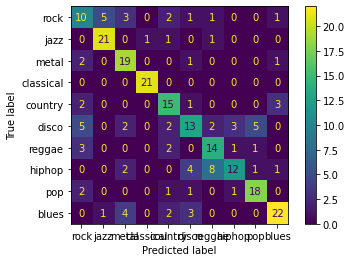

In [ ]:
#Plot the confussion matrix in order to visualize the performance
plot_confusion_matrix(clf_svm,
                      X_test_scaled,
                      y_test,
                      values_format='d',
                      display_labels = LABELS[1:])

This performance validates the well known idea that SVM are good out-of=the-box classifiers. As they perform pretty well without any optimization.


Let's use Cross Validation to optimize our model and see if a better performance can be achieved.

Also, Radial kernel will be used as it extends the problem to infinite dimensions. Which a priori turns it into a more flexible option than polynomial kernels

In [ ]:
#Optimization with Cross Validation and GridSearchCV
#Parameter grid

param_grid = [{'C': [0.5,1,10,100],
               'gamma': ['scale', 1, 0.1,0.01,0.001,0.0001],
              'kernel': ['rbf']},
              ]
#Model definition
prediction_model = SVC(random_state = 7)
#scores = ['accuracy', 'precision']
scores = ['accuracy',]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    #gs = GridSearchCV(estimator=prediction_model, param_grid=param_grid, cv=5, scoring='%s_macro' % score)
    gs = GridSearchCV(estimator=prediction_model, param_grid=param_grid, cv=5, scoring='accuracy')
    gs.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(gs.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, gs.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Grid scores on development set:

0.607 (+/-0.099) for {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
0.108 (+/-0.009) for {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
0.136 (+/-0.019) for {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
0.603 (+/-0.096) for {'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}
0.498 (+/-0.060) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}
0.196 (+/-0.053) for {'C': 0.5, 'gamma': 0.0001, 'kernel': 'rbf'}
0.664 (+/-0.106) for {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.119 (+/-0.007) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.328 (+/-0.026) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.668 (+/-0.109) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.547 (+/-0.059) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.270 (+/-0.056) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.676 (+/-0.075) for {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.120 (+

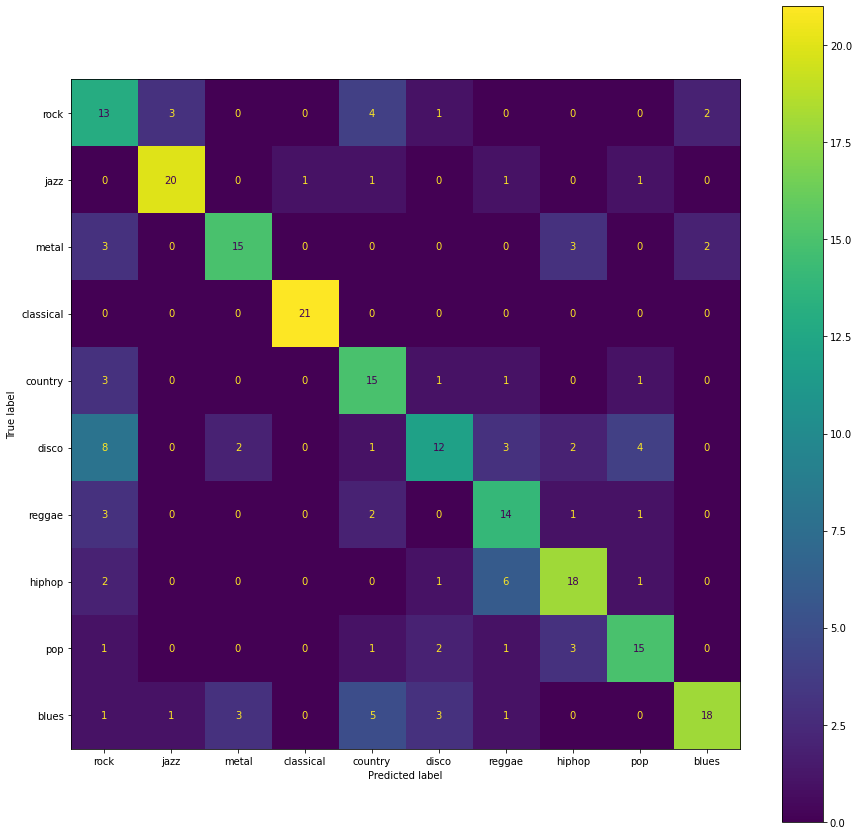

In [ ]:
clf_svm = SVC(random_state = 7, C=10, gamma=0.01, kernel='rbf')
clf_svm.fit(X_train_scaled,y_train)


fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(gs,
                      X_test_scaled,
                      y_test,
                      values_format='d',
                      display_labels = LABELS[1:],
                      ax = ax)

After the optimization of the hyperparameters of our moder, the improvement is not noticiable. Again, it's well known that optimization in SVM classifiers rarely generate any improvement.

### Clustering Methods

The proposal is to apply three methods of clustering methods:

* KMeans: Technique where the observations/inputs are asigned to the cluster with the nearest center. And its mean is recalculated until no reassignations takes place.
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

* Spectral Clustering: Technique where the approach is used to identify communities of nodes in a graph based on the edges connecting them. It uses eigenvectors of the similarity matrix of nxn to perform  dimensionality reduction before clustering in fewer dimensions. 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering

* DBSCAN: Clustering technique based on identifing high density regions.
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
#Split data into inputs and outputs
X = df_tot.drop('labels', axis=1).copy()
y = df_tot['labels'].copy()
#For clearer results visualization
LABELS = DATA_DICT['mapping']
LABELS = LABELS[1:]
print(LABELS)


#Spliting the data dataframe into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=7)

X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

['blues', 'hiphop', 'jazz', 'reggae', 'rock', 'metal', 'country', 'pop', 'classical', 'disco']


In [ ]:
#Define the benchmarks for the classification based on Clustering
def bench_k_means(estimator, data,labels):
    estimator.fit(data)
    print('\t%.3f\t%.3f\t%.3f'
          % (metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_)))

##### Kmeans

In [ ]:
bench_k_means(KMeans(init='k-means++', n_clusters=10, n_init=10), data=X_train_scaled, labels = y_train)

	0.355	0.374	0.364


In [ ]:
#Direct model
kmean_model =KMeans(init='k-means++', n_clusters=10, n_init=10).fit(X_train_scaled)

As the performance is considerably worst than the obtained by SVM, lets apply PCA reduction as a first proposition to improve this performance

In [ ]:
#PCA model
pca = PCA(n_components=10).fit(X_train_scaled)
bench_k_means(KMeans(init=pca.components_, n_clusters=10, n_init=1),
              data=X_train_scaled,
              labels = y_train)

	0.354	0.366	0.360


No improvement is appreciated. Lets take a look at this situation in order to find a possible explanation.

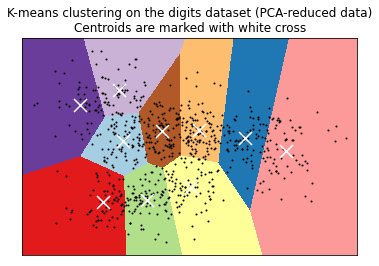

In [ ]:
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(X_train_scaled)
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

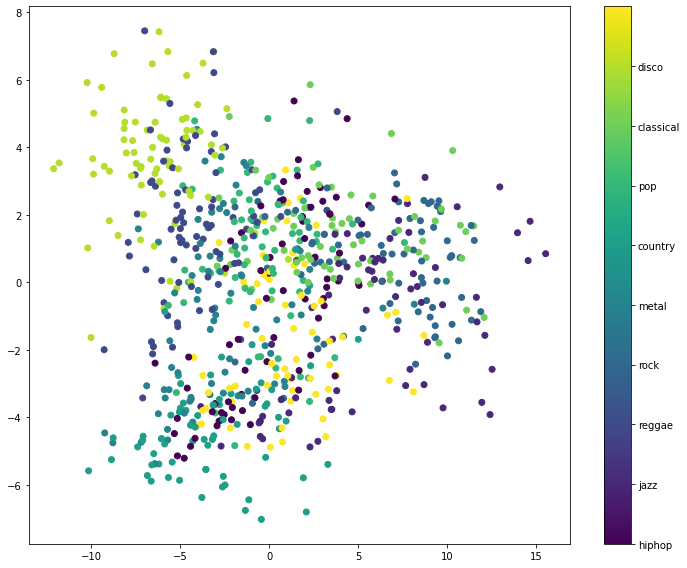

In [ ]:
# Original data plot

# Formatter
formatter = plt.FuncFormatter(lambda i, *args: '{}'.format(LABELS[i]))
# Graph definition
plt.figure(figsize=(10,8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_train)
plt.colorbar(ticks=[i for i in range(len(LABELS))], format=formatter)
#plt.xlabel(feature)
#plt.ylabel(feature1)

plt.tight_layout()
plt.show()

This plot clearly indicates that  consider only 2 components it's unfeasible, because all clusters/categories are completely overlap.

Lets take a look at the *scree plot* which gives us information about the relative importance of the different principal components in representation of the raw data

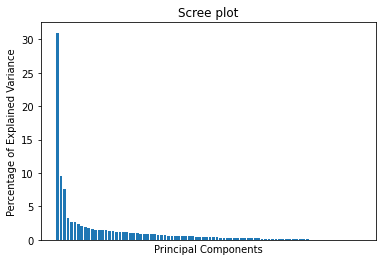

In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_*100,decimals=1)
labels_pca = [str(x) for x in range(1,len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis = 'x',
    which='both',
    bottom =False,
    top = False,
    labelbottom = False,
)

plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

According to this graph, the  PC1 accounts for a relative large amount of variation in the raw data, i.e, it will be a good candidate for the ROM representation. However, PC2 is not considerably larger than PC3 and PC4. 
Idealy, PC1 and PC2 should be considerably larger than the other components if expecting to achieve good performance considering a reduced amount of components

I will take this first four PC's to train a model and see the performance

In [ ]:
#PCA model
pca = PCA(n_components=4).fit(X_train_scaled)
X_train_pca = pca.fit_transform(X_train_scaled)
bench_k_means(KMeans(init='k-means++', n_clusters=10, n_init=1),
              data=X_train_pca,
              labels = y_train)

	0.371	0.380	0.376


The performace doesn't improve noticiably. 

The main reason may be that the data is not linearly separable. A possible solution is to use a method based on clustering that ables to deal with this condition. For example Spectral Clustering


##### Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering
Spectral_model = SpectralClustering(
    n_clusters=10,
    eigen_solver=None,
    n_components=None,
    random_state=None,
    n_init=10,
    gamma=0.1,
    affinity='rbf',
    n_neighbors=10,
    eigen_tol=0.0,
    assign_labels='kmeans',
    degree=3,
    coef0=1,
    kernel_params=None,
    n_jobs=None,)

In [ ]:
bench_k_means(Spectral_model, data=X_train_scaled, labels = y_train)

	0.139	0.352	0.199


In [ ]:
#Handmade optimization of Spectral clustering hyperparameters
gammas = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
          0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
n_neighborsss=[1, 5, 10, 25 ,50, 100]

for i in range(len(gammas)):
  for j in range(len(n_neighborsss)):
    print('Training with Gamma:{} and N_neighbors:{}'.format(gammas[i],n_neighborsss[j]))
    Spectral_model = SpectralClustering(
        n_clusters=10,
        eigen_solver=None,
        n_components=None,
        random_state=None,
        n_init=10,
        gamma=gammas[i],
        affinity='rbf',
        n_neighbors=n_neighborsss[j],
        eigen_tol=0.0,
        assign_labels='kmeans',
        degree=3,
        coef0=1,
        kernel_params=None,
        n_jobs=None,)
    bench_k_means(Spectral_model, data=X_train_scaled, labels = y_train)

Training with Gamma:0.01 and N_neighbors:1


NameError: ignored

* Gamma = 0.09
* n_neighbors=25

seems  to be a good tuning in the hyperparameters


In [ ]:
#PCA model
pca = PCA(n_components=4).fit(X_train_scaled)
X_train_pca = pca.fit_transform(X_train_scaled)
Spectral_model = SpectralClustering(
    n_clusters=10,
    eigen_solver=None,
    n_components=None,
    random_state=None,
    n_init=10,
    gamma=0.09,
    affinity='rbf',
    n_neighbors=25,
    eigen_tol=0.0,
    assign_labels='kmeans',
    degree=3,
    coef0=1,
    kernel_params=None,
    n_jobs=None,)
bench_k_means(Spectral_model,
              data=X_train_pca,
              labels = y_train)

NameError: ignored

In [ ]:
X_test_pca = pca.fit_transform(X_test_scaled)
bench_k_means(Spectral_model,
              data=X_test_pca,
              labels = y_test)

The performance is better than Kmeans, but it is still under the expected considering the 67% obtained applying SVM.

##### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

#Handmade optimization of DBSCAN hyperparameters       
EPS = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
          0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
min_samplesss=[1, 5, 10, 25 ]

for i in range(len(EPS)):
  for j in range(len(min_samplesss)):
    print('Training with EPS:{} and Min_samples:{}'.format(EPS[i],min_samplesss[j]))
    dbscan_model = DBSCAN(
        eps=EPS[i],
        min_samples=min_samplesss[j],
        metric='euclidean',)
    bench_k_means(dbscan_model, data=X_train_scaled, labels = y_train)

Training with EPS:0.01 and Min_samples:1
	0.999	0.348	0.517
Training with EPS:0.01 and Min_samples:5
	-0.000	1.000	-0.000
Training with EPS:0.01 and Min_samples:10
	-0.000	1.000	-0.000
Training with EPS:0.01 and Min_samples:25
	-0.000	1.000	-0.000
Training with EPS:0.02 and Min_samples:1
	0.999	0.348	0.517
Training with EPS:0.02 and Min_samples:5
	-0.000	1.000	-0.000
Training with EPS:0.02 and Min_samples:10
	-0.000	1.000	-0.000
Training with EPS:0.02 and Min_samples:25
	-0.000	1.000	-0.000
Training with EPS:0.03 and Min_samples:1
	0.999	0.348	0.517
Training with EPS:0.03 and Min_samples:5
	-0.000	1.000	-0.000
Training with EPS:0.03 and Min_samples:10
	-0.000	1.000	-0.000
Training with EPS:0.03 and Min_samples:25
	-0.000	1.000	-0.000
Training with EPS:0.04 and Min_samples:1
	0.999	0.348	0.517
Training with EPS:0.04 and Min_samples:5
	-0.000	1.000	-0.000
Training with EPS:0.04 and Min_samples:10
	-0.000	1.000	-0.000
Training with EPS:0.04 and Min_samples:25
	-0.000	1.000	-0.000
Training

In [ ]:
#PCA model
pca = PCA(n_components=4).fit(X_train_scaled)
X_train_pca = pca.fit_transform(X_train_scaled)
dbscan_model = DBSCAN(
    eps=0.1,
    min_samples=1,
    metric='euclidean',)
bench_k_means(dbscan_model,
              data=X_train_pca,
              labels = y_train)

	0.999	0.348	0.517


In [ ]:
X_test_pca = pca.fit_transform(X_test_scaled)
bench_k_means(dbscan_model,
              data=X_test_pca,
              labels = y_test)

The performance is better than Kmeans and, again, it is still under the expected considering the 67% obtained applying SVM.

### Dimensionality Reduction
 The idea of this section is to apply different techniques of ROM in order to reduce the number of features that are used to train the classification models mentioned above.

 Methods based on proyection of the feature space:

 * Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data. 

 * Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.

* Neighborhood Components Analysis (NCA) tries to find a feature space such that a stochastic nearest neighbor algorithm will give the best accuracy. Like LDA, it is a supervised method.


Methods based on agglomeration: 
* Feature agglomeration : applies Hierarchical clustering to group together features that behave similarly.

Non linear Methods#
* Autoenconders: The dimensionality reduction is performed by a simetric NN trained to generate a bottle neck of information, i.e, representing the data using a reduced number of features, and then expand this reduced data to obtain the input data.

In [13]:
#imports

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

In [14]:
#Split data into inputs and outputs
X = df_tot.drop('labels', axis=1).copy()
y = df_tot['labels'].copy()
#For clearer results visualization
LABELS = DATA_DICT['mapping']
print(LABELS)
#Spliting the data dataframe into train and test sets
random_state = 7

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=random_state
)


['genres', 'metal', 'country', 'reggae', 'blues', 'pop', 'hiphop', 'disco', 'jazz', 'rock', 'classical']


#### Projection methods

Lets start comparing the three projection methods mentioned above trying to use only 2 dimension, so it's possible to plot in a 2D graph the result

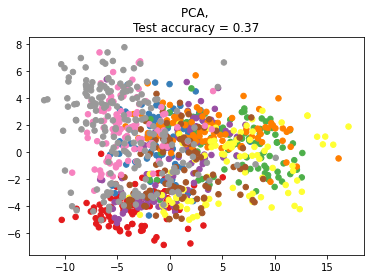

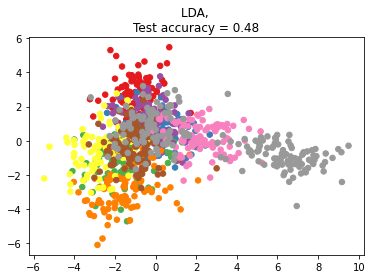

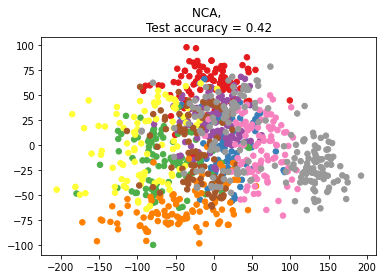

In [17]:
dim = 88
n_classes = len(LABELS)-1

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

# Use a support vector machine classifier to evaluate the methods
clf_svm = SVC(random_state = random_state, C=10, gamma=0.01, kernel='rbf')
#knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]


for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a support vector machine classifier  on the embedded training set
    clf_svm.fit(model.transform(X_train), y_train)

    # Compute the SVM accuracy on the embedded test set
    acc_svm = clf_svm.score(model.transform(X_test), y_test)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title(
        "{}, \nTest accuracy = {:.2f}".format(name, acc_svm)
    )
plt.show()

From previous simulation, we can conclude that LDA has the best performance for this problem.

However, the perfomance is quiet poor. Lets analyse the weigth of each dimension in order to improve this.

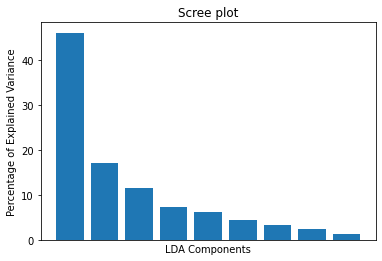

In [18]:
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_scaled, y_train)

per_var = np.round(lda.explained_variance_ratio_*100,decimals=1)
labels_lda = [str(x) for x in range(1,len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis = 'x',
    which='both',
    bottom =False,
    top = False,
    labelbottom = False,
)

plt.ylabel('Percentage of Explained Variance')
plt.xlabel('LDA Components')
plt.title('Scree plot')
plt.show()

It seems that 5 first LDA components are needed to get a  90 % representation of the model.

However, according to recomendations in Sklearn, an appropiate tuning is to use as much dimension as labels we have. Which is reasonable because what we are defining are discrimination surfaces.

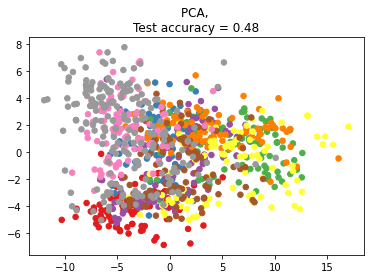

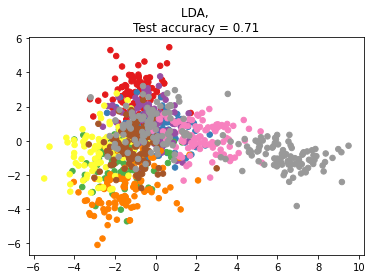

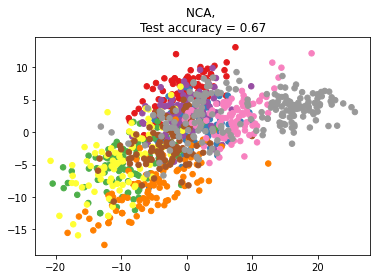

In [19]:
dim = 88
n_classes = len(LABELS)-1
n_comp = 9
# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=n_comp, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=n_comp))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=n_comp, random_state=random_state),
)

# Use a support vector machine classifier to evaluate the methods
clf_svm = SVC(random_state = random_state, C=10, gamma=0.01, kernel='rbf')
#knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]


for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a support vector machine classifier  on the embedded training set
    clf_svm.fit(model.transform(X_train), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_svm = clf_svm.score(model.transform(X_test), y_test)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title(
        "{}, \nTest accuracy = {:.2f}".format(name, acc_svm)
    )
plt.show()

Using a number of discriminating surface equal to the number of classes, i.e, nine, in this case. The dimensionality reduction of LDA manage to improve the performance of the classifier based on SVM. In other words, not only the model works with considerably less number of features, but also, it's performances is better.

#### Agglomerative Methods

The idea is to reduce the number of features by trying to summerize similar features into equivalent ones.

In [24]:
from sklearn import  cluster


for n_clus in range(1,50):
  agglo = cluster.FeatureAgglomeration(n_clusters=n_clus)
  agglo.fit(X_train_scaled)
  X_reduced = agglo.transform(X_train_scaled)

  clf_svm = SVC(random_state = random_state, C=10, gamma=0.01, kernel='rbf')
  clf_svm.fit(X_reduced, y_train)
  acc_svm = clf_svm.score(agglo.transform(X_test_scaled), y_test)
  print('Accuracy: {}, with {} clusters'.format(acc_svm,n_clus))

Accuracy: 0.2661290322580645, with 1 clusters
Accuracy: 0.33064516129032256, with 2 clusters
Accuracy: 0.36693548387096775, with 3 clusters
Accuracy: 0.4435483870967742, with 4 clusters
Accuracy: 0.5, with 5 clusters
Accuracy: 0.4959677419354839, with 6 clusters
Accuracy: 0.5, with 7 clusters
Accuracy: 0.4838709677419355, with 8 clusters
Accuracy: 0.5, with 9 clusters
Accuracy: 0.4879032258064516, with 10 clusters
Accuracy: 0.5161290322580645, with 11 clusters
Accuracy: 0.4959677419354839, with 12 clusters
Accuracy: 0.5120967741935484, with 13 clusters
Accuracy: 0.4959677419354839, with 14 clusters
Accuracy: 0.5161290322580645, with 15 clusters
Accuracy: 0.5161290322580645, with 16 clusters
Accuracy: 0.5241935483870968, with 17 clusters
Accuracy: 0.5282258064516129, with 18 clusters
Accuracy: 0.5282258064516129, with 19 clusters
Accuracy: 0.5282258064516129, with 20 clusters
Accuracy: 0.5201612903225806, with 21 clusters
Accuracy: 0.5685483870967742, with 22 clusters
Accuracy: 0.564516

According to this sweep, 27 clusters is an good choice in the trade of between nro of clusters and accuracy. 

Lets combine with LDA to define optimal discrimination surface based on this new space of 27 clustered features.

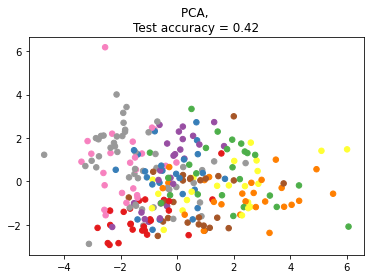

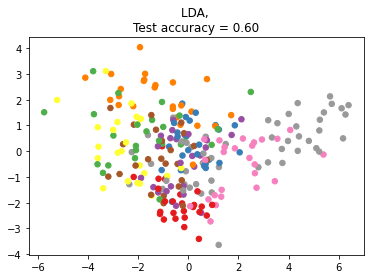

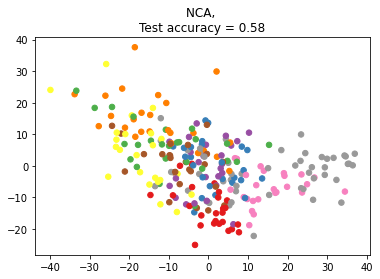

In [40]:
dim = 27
n_classes = len(LABELS)-1
n_comp = 9
# Agglomeration
agglo = cluster.FeatureAgglomeration(n_clusters=dim)
agglo.fit(X_train_scaled)
X_reduced = agglo.transform(X_train_scaled)


# Reduce dimension to 2 with PCA
pca = PCA(n_components=n_comp, random_state=random_state)

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=n_comp)

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = NeighborhoodComponentsAnalysis(n_components=n_comp, random_state=random_state)

# Use a support vector machine classifier to evaluate the methods
clf_svm = SVC(random_state = random_state, C=10, gamma=0.01, kernel='rbf')
#knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]


for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    # Fit the method's model
    model.fit(X_reduced, y_train)

    # Fit a support vector machine classifier  on the embedded training set
    clf_svm.fit(model.transform(X_reduced), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    X_reduced_test = agglo.transform(X_test_scaled)
    acc_svm = clf_svm.score(model.transform(X_reduced_test), y_test)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X_reduced_test)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test, s=30, cmap="Set1")
    plt.title(
        "{}, \nTest accuracy = {:.2f}".format(name, acc_svm)
    )
plt.show()

From the above results, it can be conclude that agglomerate similar features and, optionally, then apply a LDA projection has a worst performance than applying only a LDA projection over the entire feature space.

#### Autoencoders

The main idea is to use a NN to generate a codification of the feature space in a reduced and encoded feature space. Then, use this representation to train the model, in this case, a classifier. 

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Flatten, Dense, Lambda
from tensorflow.keras.losses import MeanSquaredError

#Define the model
class Autoencoder(Model):
  def __init__(self, latent_dim=27):
    super(Autoencoder, self).__init__()

    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
                                        Flatten(),
                                        Dense(latent_dim, activation='linear'),
                                        
    ])
    self.decoder = tf.keras.Sequential([
                                        Dense(88, activation = 'linear'),
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [67]:
#Fit the model
autoencoder = Autoencoder()
autoencoder.compile(optimizer = 'adam', loss = MeanSquaredError())
autoencoder.fit(X_train_scaled, X_train_scaled,epochs=200)

Epoch 1/200
24/24 [==============================] - 0s 1ms/step - loss: 1.3371
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.9596
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.7531
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6346
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.5575
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 0.5015
Epoch 7/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4610
Epoch 8/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4296
Epoch 9/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4041
Epoch 10/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3823
Epoch 11/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3631
Epoch 12/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3468
Epoch 13/200
24/24 [=================

In [68]:
#Encode
X_train_encoded = autoencoder.encoder(X_train_scaled).numpy()
X_train_encoded.shape

(741, 27)

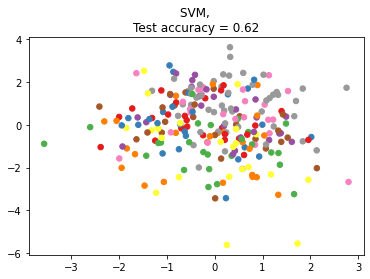

In [74]:
#Train the model
plt.figure()

clf_svm = SVC(random_state = random_state, C=10, gamma=0.01, kernel='rbf')
# Fit a support vector machine classifier  on the embedded training set
clf_svm.fit(X_train_encoded, y_train)

# Compute SVM accuracy on the test set
X_test_encoded = autoencoder.encoder(X_test_scaled).numpy()
acc_svm = clf_svm.score(X_test_encoded, y_test)

X_embedded = X_test_encoded

# Plot the projected points and show the evaluation score
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test, s=30, cmap="Set1")
plt.title(
    "SVM, \nTest accuracy = {:.2f}".format( acc_svm)
)
plt.show()

According to this result, direct applycation of LDA is still the best option. Probably indicating that the encoded feature space is harder to separate than the original. Even with a reduced number of dimensions.

Lets analyse the perfomance combining both techniques...

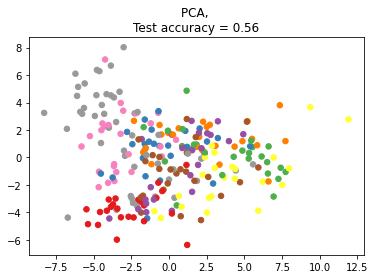

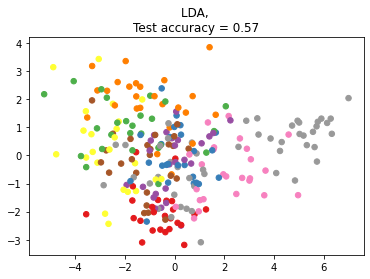

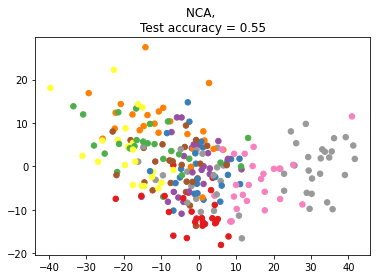

In [72]:
#Combining the encoded data with projection

dim = 27
n_classes = len(LABELS)-1
n_comp = 9
# Reduce dimension to 9 with PCA
pca = PCA(n_components=n_comp, random_state=random_state)

# Reduce dimension to 9 with LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=n_comp)

# Reduce dimension to 9 with NeighborhoodComponentAnalysis
nca = NeighborhoodComponentsAnalysis(n_components=n_comp, random_state=random_state)

# Use a support vector machine classifier to evaluate the methods
clf_svm = SVC(random_state = random_state, C=10, gamma=0.01, kernel='rbf')


# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]


for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
   
    # Fit the method's model
    model.fit(X_train_encoded, y_train)

    # Fit a support vector machine classifier  on the embedded training set
    clf_svm.fit(model.transform(X_train_encoded), y_train)

    # Compute the SVM accuracy on the embedded test set
    acc_svm = clf_svm.score(model.transform(X_test_encoded), y_test)

    # Embed the data set in 9 dimensions using the fitted model
    X_embedded = model.transform(X_test_encoded)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test, s=30, cmap="Set1")
    plt.title(
        "{}, \nTest accuracy = {:.2f}".format(name, acc_svm)
    )
plt.show()

_In conclusion_: For this dataset, the best alternative is to apply a dimensionality reduction based on LDA using a number of final dimension equal to the number of labels. 
Combining this process with SVM classifier, an accuracy performance of 71% is achieved.